### Predicting $SPY Price with a LSTM Neural Network

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

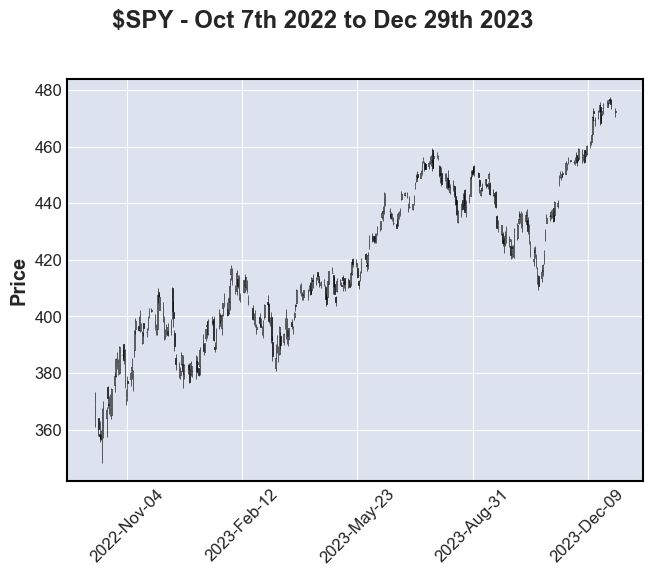

Number of days used for |training: 310| and |testing: 101|


In [3]:
'''
    Plot the candlestick chart of the training data

    Train with: October 7th 2022 - December 29th 2023
    Test on: January 1st 2024 - March 1st 2024
'''

df = pd.read_csv('SPY.csv', index_col=0, parse_dates=['Date'], usecols=['Date', 'Open', 'High', 'Low', 'Close'])

df_train, df_test = df.loc['2022-10-07':'2024-01-02'], df.loc['2023-10-06':'2024-03-01']

mpf.plot(df_train, type='candle', show_nontrading=True, title='$SPY - Oct 7th 2022 to Dec 29th 2023')

print(f'Number of days used for |training: {df_train.shape[0]}| and |testing: {df_test.shape[0]}|')

In [6]:
'''
    Preprocess the data with the MinMax scaler

    Input will only consist of 60 consecutive days worth of
    normalized close prices, and the output will be the 61st
    day's price
'''

train = np.delete(df_train.values, [0, 1, 2], axis=1).astype(np.float32)
test = np.delete(df_test.values, [0, 1, 2], axis=1).astype(np.float32)

scaler_train, scaler_test = MinMaxScaler(feature_range=(-1, 1)), MinMaxScaler(feature_range=(-1, 1))
train, test = scaler_train.fit_transform(train), scaler_test.fit_transform(test)

'''
    First 60 days are history

    For training output, 310 - 60 = 250 days will be looked at
    For testing output, 101 - 60 = 41 days will be looked at
'''

train_in, train_out = np.empty((250, 60, 1)), np.empty((250, 1))
for i in range(250):
    train_in[i] = train[i:i + 60]
    train_out[i] = train[i + 60]

test_in, test_out = np.empty((41, 60, 1)), np.empty((41, 1))
for i in range(41):
    test_in[i] = test[i:i + 60]
    test_out[i] = test[i + 60]

train_in, train_out, test_in, test_out = torch.tensor(train_in, dtype=torch.float32), torch.tensor(train_out, dtype=torch.float32), torch.tensor(test_in, dtype=torch.float32), scaler_test.inverse_transform(test_out)

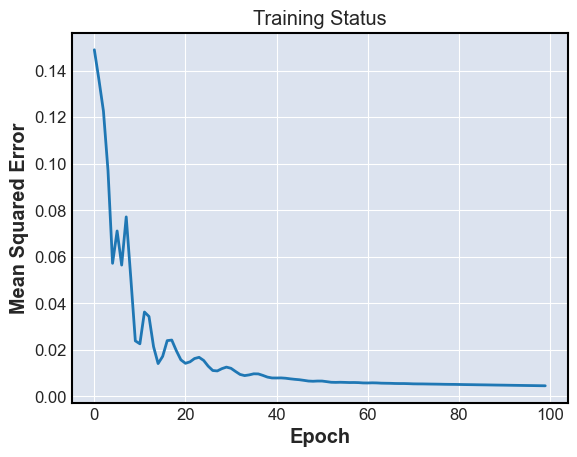

In [11]:
'''
    LSTM hyperparameters:
        input dimension - 1 feature - closing price
        hidden dimension - 32 memory cells
        number of layers - 2 stacked LSTM models
        output dimension - 1 output - expected price
'''

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=True)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=True)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

model = LSTM(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

'''
    Now for the actual training process
    Model is updated 100 times
'''

hist = np.zeros(100)
for epoch in range(100):
    train_pred = model(train_in)
    loss = loss_fn(train_pred, train_out)
    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(hist, label="Mean Squared Error")
plt.ylabel("Mean Squared Error")
plt.xlabel("Epoch")
plt.title("Training Status")
plt.show()

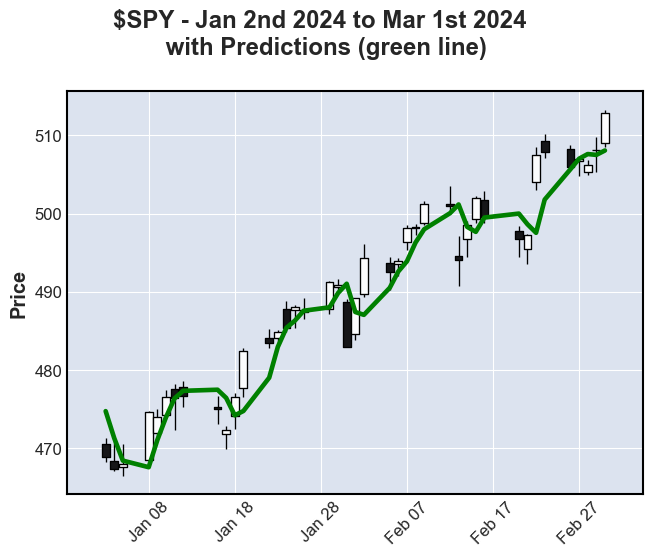

Accuracy with 1% error tolerance: 80.49%


In [12]:
'''
Use the LSTM Neural Network to make predictions on new data
'''

test_pred = model(test_in)
test_pred = scaler_test.inverse_transform(test_pred.detach().numpy())

df_pred = pd.DataFrame(test_pred, columns=['Predicted Close'], index=df.index[-len(test_pred):])
df_actual = df.loc['2024-01-03':'2024-03-01']

mpf.plot(df_actual, type='candle', show_nontrading=True, title='$SPY - Jan 2nd 2024 to Mar 1st 2024 \n with Predictions (green line)', addplot=mpf.make_addplot(df_pred['Predicted Close'], color='green', secondary_y=False))

print(f'Accuracy with 1% error tolerance: {np.sum(np.abs(test_pred - test_out) <= 5) / len(test_out) * 100:.2f}%')